# Data analysis on Longitudinal Vehicle Dynamics Simulations

This python file exists to use machine learning techniques for the regression problem of predicting the right motor torque to bring a vehicle from a start state to an end state. 

## We will be using the following libraries
pip install 
numpy
pandas
ipykernel
scikit-learn 
matplotlib
xgboost


In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

First, we will import the data 

In [51]:
import pandas as pd

acc_data = pd.read_csv('simResults/accelerationSimsSummary.csv')
brake_data = pd.read_csv('simResults/brakeSimsSummary.csv')
coast_data = pd.read_csv('simResults/coastSimsSummary.csv')

In [52]:
print(acc_data.head(2))
#print(brake_data.head(2))
#print(coast_data.head(2))

# the size of each data set
print('acc_data size: ', acc_data.shape)
print('brake_data size: ', brake_data.shape)
print('coast_data size: ', coast_data.shape)

   Xs    Vs        As           Xe        Ve        Ae   avg_acc  time  Tm  Tb
0   0  0.00  0.000000      0.00000   0.00000  0.000000  0.000000     0   0   0
1   0  0.01  3.284619  15905.34733  31.63097  0.024179  0.052702   600  60   0
acc_data size:  (20, 10)
brake_data size:  (400, 10)
coast_data size:  (20, 10)


In [53]:
combined_df = pd.concat([acc_data, brake_data, coast_data])
print(combined_df.head(2))
# the size is 
print(combined_df.shape)

    Xs    Vs        As           Xe        Ve        Ae   avg_acc   time  Tm  \
0  0.0  0.00  0.000000      0.00000   0.00000  0.000000  0.000000    0.0   0   
1  0.0  0.01  3.284619  15905.34733  31.63097  0.024179  0.052702  600.0  60   

   Tb  
0   0  
1   0  
(440, 10)


The datasets have been stacked correctly

In [54]:
X = combined_df.drop(['Tm', 'Tb'], axis=1)
y = combined_df['Tm'] - combined_df['Tb']
#print the shapes of each
print(X.shape)
print(y.shape)

(440, 8)
(440,)


In [55]:
# Lets make some test data, the test data should consist of a beginning and end state

X0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
V0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
A0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# the start state
# we will constrict the start state to have zero accelerations
Xs = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Vs = np.array([1.0, 5.0, 10.0, 7.0, 6.0, 15.0, 20.0])
As = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# combine the start states into a matrix 
startStates = np.vstack((Xs, Vs, As)).T
print(startStates.shape)

# the end state
# the end state is the vehicle stopped at some position
Xe = np.array([1.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0])
Ve = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Ae = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# combine the end states into a matrix
endStates = np.vstack((Xe, Ve, Ae)).T
print(endStates.shape)

(7, 3)
(7, 3)


#### from these states we can calculate the time to complete the maneuver and average acceleration

Goal vehicle state : [X,V,A]end

Start vehicle state : [X,V,A]start

[X,V,A]end - [X,V,A]start = [X,V,A]change

A_needed = Vc / Time  (m/s^2)

Time = Xc / Avg_V (s) 

Avg_V = Vstart + Vchange/2  (m/s) 

Resulting in: A_needed = Vc (Vs + Vc/2) / Xc (m/s^2)

In [56]:
# define a function that takes the start state and end state and returns the time to complete the maneuver and average acc
def get_time_and_acc(startState, endState):
    # the format of the start and end state is [x, v, a]
    # the start state is the initial state of the vehicle
    # the end state is the final state of the vehicle

    # the change in position, velocity, and acceleration
    dx = endState[0] - startState[0]
    dv = endState[1] - startState[1]
    da = endState[2] - startState[2]
    
    # the average velocity
    v_avg = startState[1] + dv/2.0

    # the time to complete the maneuver
    t = dx/v_avg

    # the needed acceleration
    a = dv/t

    return t, a

t:  2.0 a:  -0.5
t:  10.0 a:  -0.1
t:  20.0 a:  -0.05
t:  40.0 a:  -0.025
t:  60.0 a:  -0.016666666666666666
t:  100.0 a:  -0.01
t:  200.0 a:  -0.005
t:  0.4 a:  -12.5
t:  2.0 a:  -2.5
t:  4.0 a:  -1.25
t:  8.0 a:  -0.625
t:  12.0 a:  -0.4166666666666667
t:  20.0 a:  -0.25
t:  40.0 a:  -0.125
t:  0.2 a:  -50.0
t:  1.0 a:  -10.0
t:  2.0 a:  -5.0
t:  4.0 a:  -2.5
t:  6.0 a:  -1.6666666666666667
t:  10.0 a:  -1.0
t:  20.0 a:  -0.5
t:  0.2857142857142857 a:  -24.5
t:  1.4285714285714286 a:  -4.8999999999999995
t:  2.857142857142857 a:  -2.4499999999999997
t:  5.714285714285714 a:  -1.2249999999999999
t:  8.571428571428571 a:  -0.8166666666666667
t:  14.285714285714286 a:  -0.49
t:  28.571428571428573 a:  -0.245
t:  0.3333333333333333 a:  -18.0
t:  1.6666666666666667 a:  -3.5999999999999996
t:  3.3333333333333335 a:  -1.7999999999999998
t:  6.666666666666667 a:  -0.8999999999999999
t:  10.0 a:  -0.6
t:  16.666666666666668 a:  -0.36
t:  33.333333333333336 a:  -0.18
t:  0.13333333333333333 a:

Text(0.5, 1.0, 'Time vs Acceleration for each maneuver')

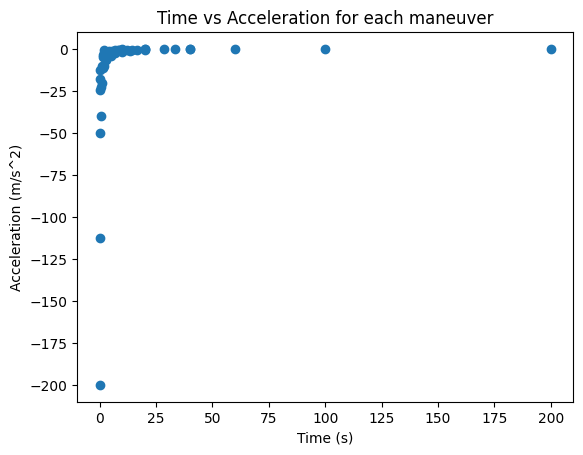

In [57]:
# double for loop to calculate combinations 
results = []
for i in range(startStates.shape[0]):
    for j in range(endStates.shape[0]):
        # get the start and end state
        startState = startStates[i, :]
        endState = endStates[j, :]
        
        # get the time and acceleration
        t, a = get_time_and_acc(startState, endState)

        # print the t and a
        print('t: ', t, 'a: ', a)

        # create an array with start state end state time and acceleration
        result = np.hstack((startState, endState, a, t))
        
        # append result to list
        results.append((result))

# convert the results to a numpy array
results = np.array(results)
print(results.shape)

# plot the t vs a for each maneuver
plt.figure()
plt.plot(results[:, 7], results[:, 6], 'o')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Time vs Acceleration for each maneuver')

Lets reduce the test points 

In [58]:
# trim results where acceleration is under -9.81 m/s^2
results_trimmed = results[results[:, 6] > -9.81, :]
print(results_trimmed.shape)

# trim the results where the time is greater than 70 seconds
results_trimmed2 = results_trimmed[results_trimmed[:, 7] < 70, :]
print(results_trimmed2.shape)

(37, 8)
(35, 8)


Text(0.5, 1.0, 'Slowing down sims Acceleration vs. Time')

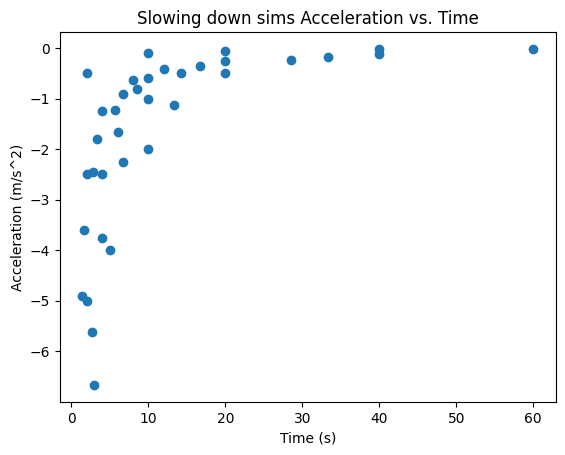

In [72]:
# plot the trimmed results
plt.figure()
plt.plot(results_trimmed2[:, 7], results_trimmed2[:, 6], 'o')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Slowing down sims Acceleration vs. Time')

In [62]:
# rename results to X_test
X_test = results_trimmed2
print(X_test.shape)

(35, 8)


Now lets train multiple machine learning algorithms on this data, and then input test cases to test back in Simulink

### Linear Models 

In [70]:
# train a linear regression model
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
y_pred_lm = model.predict(X_test)

# train an SVM model
from sklearn import svm
clf = svm.SVR() 
clf.fit(X, y)
y_pred_svm = clf.predict(X_test)

# save the results to a csv file
Xtest = pd.DataFrame(X_test, columns=['Xs', 'Vs', 'As', 'Xe', 'Ve', 'Ae', 'a', 't'])
y_pred_lm = pd.DataFrame(y_pred_lm, columns=['Tm-Tb'])
y_pred_svm = pd.DataFrame(y_pred_svm, columns=['Tm-Tb'])
Xtest.to_csv('mlPredictions/Xtest.csv', index=False)
y_pred_lm.to_csv('mlPredictions/y_pred_lm.csv', index=False)
y_pred_svm.to_csv('mlPredictions/y_pred_svm.csv', index=False)

/Users/brianlesko/Documents/VehicleSystems/Modeling/LongitudinalDynamics/simDataAnalysis/virtualEnv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/brianlesko/Documents/VehicleSystems/Modeling/LongitudinalDynamics/simDataAnalysis/virtualEnv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Tree Model

In [71]:
# train an xgb model
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model.fit(X, y)
y_pred_xgb = xgb_model.predict(X_test)

# save the results to a csv file
y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=['Tm-Tb'])
y_pred_xgb.to_csv('mlPredictions/y_pred_xgb.csv', index=False)

[11:41:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
